In [38]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy.signal import periodogram, spectrogram, butter, lfilter
# from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

# Calibration
Recording of the device at rest for 5 minutes

In [39]:
df = pd.read_csv("../data/still.csv")

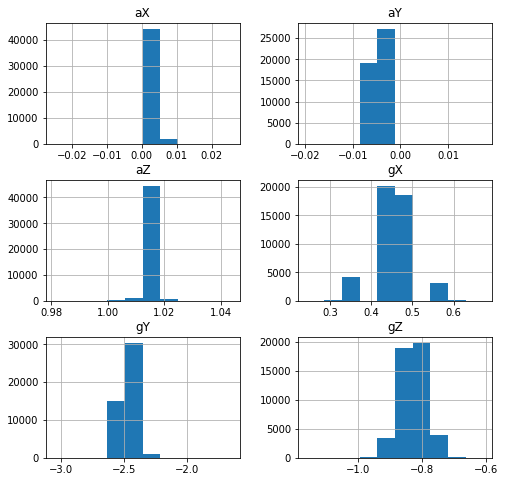

In [40]:
df.drop("time", axis=1).hist(figsize=(8,8))
plt.show()

There is not much variation from zero (or one in case of Z component) in acceleration values, when the device is at rest. However gyroscope values seem to consistently deviate from zero, which needs to be corrected for, if angular velocity is to be used.

# Readings from Arduino

In [85]:
df = pd.read_csv("../data/chest3.csv")
graph_samplerate = 5 # seaborn doesn't like many points
rps = 100 # records per second
df

,time,aX,aY,aZ,gX,gY,gZ
0,106194,0.925049,-0.294800,0.257080,-0.244141,-2.929688,-0.854492
1,106204,0.926758,-0.293579,0.255249,-0.366211,-3.173828,-0.793457
2,106214,0.927124,-0.296265,0.252197,-0.183105,-3.295898,-0.793457
3,106224,0.928223,-0.300903,0.247803,0.183105,-3.356934,-0.915527
4,106234,0.932739,-0.297363,0.244873,0.610352,-3.234863,-1.220703
...,...,...,...,...,...,...,...
5501,138178,0.910645,-0.282959,0.302490,0.366211,-2.807617,-0.915527
5502,138188,0.912354,-0.282837,0.300049,0.549316,-2.624512,-0.732422
5503,138198,0.912964,-0.284668,0.299316,0.488281,-2.563477,-0.671387
5504,138208,0.913086,-0.286621,0.299683,0.305176,-2.868652,-0.366211


Find vector pointing to the ground. There's a recording of standing still, before walking starts. The average vector can be used as the gravity reference, and subtracted from all the readings.

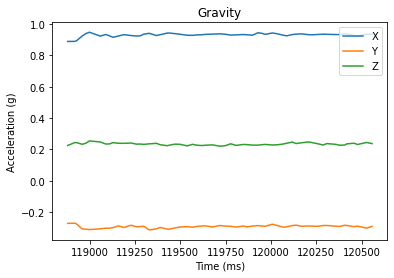

In [94]:
_df = df.iloc[22*rps:25*rps]
_dfsample = _df.iloc[::graph_samplerate]
sns.lineplot(data=_dfsample, x="time", y="aX", label="X")
sns.lineplot(data=_dfsample, x="time", y="aY", label="Y")
sns.lineplot(data=_dfsample, x="time", y="aZ", label="Z")
plt.legend()
plt.ylabel("Acceleration (g)")
plt.xlabel("Time (ms)")
plt.title("Gravity")
plt.show()

In [87]:
gravity_vector = _df.loc[:,["aX", "aY", "aZ"]].mean()

In [88]:
display("Gravity vector",gravity_vector.values,"magnitude",np.sqrt((gravity_vector**2).sum()))

'Ground vector'

array([ 0.93137248, -0.29392049,  0.2339799 ])

'magnitude'

1.0042860847765203

In [89]:
# Subtract gravity vector and multiply by 9.8 to get acceleration in m/s^2
acceleration = (df.loc[:,["aX", "aY", "aZ"]] - gravity_vector) * 9.8
acceleration["time"] = df.time

<AxesSubplot:xlabel='time', ylabel='aZ'>

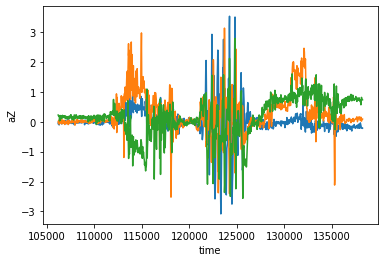

In [90]:
sns.lineplot(data=acceleration.iloc[::graph_samplerate], x="time", y="aX")
sns.lineplot(data=acceleration.iloc[::graph_samplerate], x="time", y="aY")
sns.lineplot(data=acceleration.iloc[::graph_samplerate], x="time", y="aZ")

Select only the range of readings that corresponds to a walk. We consider negative Z axis as the direction of a walk (when the device is mounted on a chest)

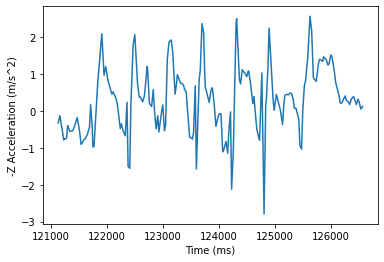

In [96]:
a, b = int(26 * rps), int(35.5 * rps)
sample = acceleration.iloc[a:b]
_sample = sample.iloc[::graph_samplerate]
sns.lineplot(data=_sample, x="time", y=-sample.aZ)
plt.xlabel("Time (ms)")
plt.ylabel("-Z Acceleration (m/s^2)")
plt.show()


* Calculate total time of the walk
* Calculate displacement at each point in time (assuming constant speed)
* Calculate average power and total work done, we assume that negative Z axis aligns with the path

In [92]:
mass = 85
time = (sample.time - sample.time.min()) / 1000
dtime = (sample.time.max() - sample.time.min()) / 1000 # Total duration of a walk in seconds
# Mean average speed. We assume the speed to be constant during the walk
vbar = 4.5 / dtime
# Estimate displacement with the constant speed. 
# In the real world scenario and for longer walks/runs, we would rely on GPS data instead  
x = [x * vbar for x in time.values]
# Integrate force with respect to displacement to get total work done
work = sp.integrate.trapz(y=-sample.aZ.values * mass, x=x)
print(f"Time: {dtime} s.\nSpeed: {vbar} m/s.\nAvg. power: {work / dtime} W.\nWork: {work} J.")


Time: 5.48 s.
Speed: 0.8211678832116788 m/s.
Avg. power: 20.991248881466902 W.
Work: 115.03204387043863 J.


# Readings from Android
See comments in the previous section for details on the analysis done

In [49]:
df2 = pd.read_csv("../data/chest-android.csv").drop("LinearAccelerometerSensor", axis=1).dropna().rename({
    "relative_time": "time",
    "AccX": "aX",
    "AccY": "aY",
    "AccZ": "aZ",
}, axis=1)
graph_samplerate2 = 1 # seaborn doesn't like many points
df2

,time,aX,aY,aZ
0,0,1.053449,7.077260,7.067683
1,84,0.871489,6.349423,6.828263
4,113,1.312023,4.912902,6.339846
8,180,-0.679953,5.219360,7.920019
18,311,0.430956,2.566584,11.109096
...,...,...,...,...
1420,22421,-0.421380,2.269703,8.427590
1424,22487,-0.641646,2.719813,9.979033
1429,22553,0.268151,2.997540,7.287950
1433,22625,-0.574608,2.422932,9.892841


<AxesSubplot:xlabel='time', ylabel='aZ'>

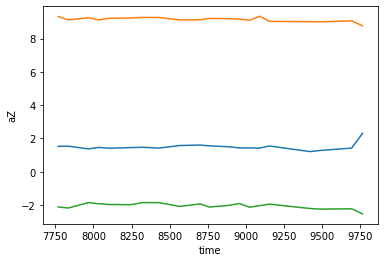

In [50]:
_df = df2.iloc[100:120]
_dfsample = _df.iloc[::graph_samplerate2]
sns.lineplot(data=_dfsample, x="time", y="aX")
sns.lineplot(data=_dfsample, x="time", y="aY")
sns.lineplot(data=_dfsample, x="time", y="aZ")

In [51]:
gravity_vector = _df.loc[:,["aX", "aY", "aZ"]].mean()

In [52]:
display("Gravity vector",gravity_vector.values,"magnitude",np.sqrt((gravity_vector**2).sum()))

'Ground vector'

array([ 1.49254534,  9.14393492, -2.05997115])

'magnitude'

9.491191627160624

In [53]:
acceleration2 = df2.loc[:,["aX", "aY", "aZ"]] - gravity_vector
acceleration2["time"] = df2.time

<AxesSubplot:xlabel='time', ylabel='aZ'>

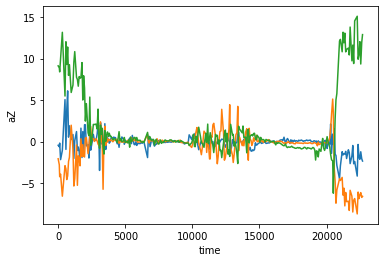

In [54]:
sns.lineplot(data=acceleration2, x="time", y="aX")
sns.lineplot(data=acceleration2, x="time", y="aY")
sns.lineplot(data=acceleration2, x="time", y="aZ")

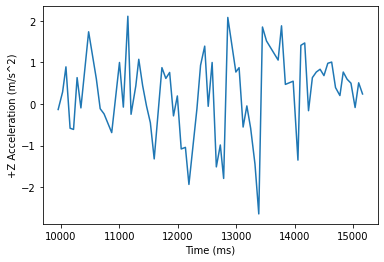

In [98]:
a, b = (120,190)
sample2 = acceleration2.iloc[a:b]
_sample2 = sample2.iloc[::graph_samplerate2]
sns.lineplot(data=_sample2, x="time", y=sample2.aZ)
plt.xlabel("Time (ms)")
plt.ylabel("+Z Acceleration (m/s^2)")
plt.show()


In [57]:
mass = 85
time = (sample2.time - sample2.time.min()) / 1000
dtime = (sample2.time.max() - sample2.time.min()) / 1000
vbar = 4.5 / dtime
x = [x * vbar for x in time.values]
work = sp.integrate.trapz(y=sample2.aZ.values * mass, x=x)
print(f"Time: {dtime} s.\nSpeed: {vbar} m/s.\nAvg. power: {work / dtime} W.\nWork: {work} J.")


Time: 5.207 s.
Speed: 0.8642212406376033 m/s.
Avg. power: 19.814510206149293 W.
Work: 103.17415464341937 J.


# Misc
Estimate velocity from acceleration by integration. The velocity keeps increasing, whereas we expect it to drop back to zero at the end of a walk

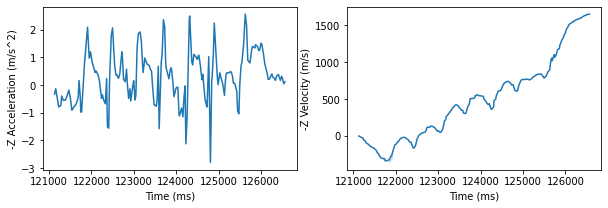

In [26]:
_sample = sample.iloc[::graph_samplerate]
fig, axs = plt.subplots(1,2,figsize=(10,3))
sns.lineplot(data=_sample, x="time", y=-sample.aZ, ax=axs[0])
velocity = sp.integrate.cumtrapz(y=-sample.aZ.values, x=sample.time)
_velocity = velocity[::graph_samplerate]
sns.lineplot(x=_sample.time.values, y=_velocity, ax=axs[1])
axs[0].set_xlabel("Time (ms)")
axs[1].set_xlabel("Time (ms)")
axs[0].set_ylabel("-Z Acceleration (m/s^2)")
axs[1].set_ylabel("-Z Velocity (m/s)")
plt.show()
